In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
%matplotlib inline


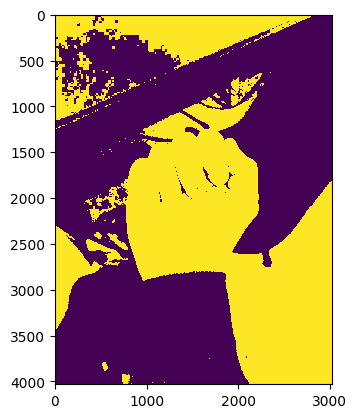

In [9]:
# Approche classique avec parcours de l'image
def isSkin(pixel):
    b = pixel[0]
    g = pixel[1]
    r = pixel[2]
    c1 = r > 95
    c2 = g > 40
    c3 = b > 20
    c4 = max(pixel) - min(pixel) > 15
    c4 = abs(int(r) - int(g)) > 15
    c5 = r > g
    c6 = r > b
    isSkin = c1 and c2 and c3 and c4 and c5 and c6
    return isSkin


def createSkinMask(src):
    img = cv2.imread(src, 1)
    height, width = img.shape[:2]
    mask = np.zeros((height, width), np.uint8)
    for i in range(height):
        for j in range(width):
            if isSkin(img[i][j]):
                mask[i][j] = 255
    return mask


skinMask = createSkinMask("./data/A_real.jpg")
plt.imshow(skinMask, interpolation="nearest")

./data/Data/Face_Dataset/Pratheepan_Dataset/FacePhoto
./data/Data/Face_Dataset/Ground_Truth/GroundT_FacePhoto
./data/Data/Face_Dataset/Pratheepan_Dataset/FacePhoto
./data/Data/Face_Dataset/Ground_Truth/GroundT_FacePhoto
1183975


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


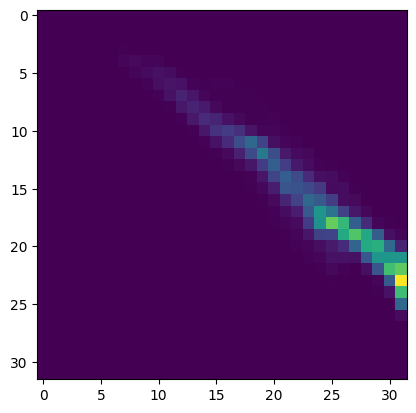

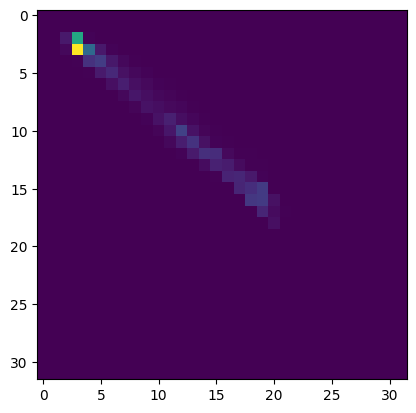

In [15]:
def compterPixels(I, k):
    return np.count_nonzero((I == k))


def inverserImage(I):
    return 255 - I


def getImagesFromResources(skin_rep, color_space):
    skindir = os.path.dirname(skin_rep)
    print(skindir)
    skin_images = []
    for filename in os.listdir(skindir):
        img = cv2.imread(os.path.join(skindir, filename))
        if img is not None:
            if color_space == "BGR":
                skin_images.append(img)
            elif color_space == "Lab":
                skin_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))
            elif color_space == "HSV":
                skin_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
            elif color_space == "Gray":
                skin_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    return skin_images


skin_images = getImagesFromResources(
    "./data/Data/Face_Dataset/Pratheepan_Dataset/FacePhoto/", "Lab"
)
assert len(skin_images) == 25  # 32

mask_images = getImagesFromResources(
    "./data/Data/Face_Dataset/Ground_Truth/GroundT_FacePhoto/", "Gray"
)
assert len(mask_images) == 25  # 32


def create_histograms(color_space, size, skin_images, mask_images):
    if color_space in ["BGR", "Lab"]:
        # Creation de l'histogramme de peau
        hist_peau = [[0 for j in range(size)] for i in range(size)]
        hist_non_peau = [[0 for j in range(size)] for i in range(size)]
        nb_pixel_peau = 0
        nb_pixel_non_peau = 0
        for img in skin_images:
            nb_pixel_peau = nb_pixel_peau + compterPixels(mask_images[0], 255)
            nb_pixel_non_peau = nb_pixel_non_peau + compterPixels(mask_images[0], 0)
            hist_peau = hist_peau + cv2.calcHist(
                [skin_images[0]], [1, 2], mask_images[0], [size, size], [0, 256, 0, 256]
            )
            hist_non_peau = hist_non_peau + cv2.calcHist(
                [skin_images[0]],
                [1, 2],
                inverserImage(mask_images[0]),
                [size, size],
                [0, 256, 0, 256],
            )
        print(nb_pixel_peau)
        hist_peau = hist_peau / nb_pixel_peau
        hist_non_peau = hist_non_peau / nb_pixel_non_peau
        p_peau_prior = nb_pixel_peau / (nb_pixel_peau + nb_pixel_non_peau)
        p_non_peau_prior = nb_pixel_non_peau / (nb_pixel_peau + nb_pixel_non_peau)
    elif color_space == "HSV":
        hist_peau = [[0 for j in range(size)] for i in range(size)]
        hist_non_peau = [[0 for j in range(size)] for i in range(size)]
        nb_pixel_peau = 0
        nb_pixel_non_peau = 0
        for img in skin_images:
            nb_pixel_peau = nb_pixel_peau + compterPixels(mask_images[0], 255)
            nb_pixel_non_peau = nb_pixel_non_peau + compterPixels(mask_images[0], 0)
            hist_peau = hist_peau + cv2.calcHist(
                [skin_images[0]], [0, 1], mask_images[0], [size, size], [0, 180, 0, 256]
            )
            hist_non_peau = hist_non_peau + cv2.calcHist(
                [skin_images[0]],
                [0, 1],
                inverserImage(mask_images[0]),
                [size, size],
                [0, 180, 0, 256],
            )
        print(nb_pixel_peau)
        hist_peau = hist_peau / nb_pixel_peau
        hist_non_peau = hist_non_peau / nb_pixel_non_peau
        p_peau_prior = nb_pixel_peau / (nb_pixel_peau + nb_pixel_non_peau)
        p_non_peau_prior = nb_pixel_non_peau / (nb_pixel_peau + nb_pixel_non_peau)
    return hist_peau, hist_non_peau, p_peau_prior, p_non_peau_prior


hist_peau_RG, hist_non_peau_RG, peau_prior, non_peau_prior = create_histograms(
    "BGR",
    32,
    getImagesFromResources(
        "./data/Data/Face_Dataset/Pratheepan_Dataset/FacePhoto/", "BGR"
    ),
    getImagesFromResources(
        "./data/Data/Face_Dataset/Ground_Truth/GroundT_FacePhoto/", "Gray"
    ),
)

plt.imshow(hist_peau_RG, interpolation="nearest")
plt.show()
plt.imshow(hist_non_peau_RG, interpolation="nearest")
plt.show()

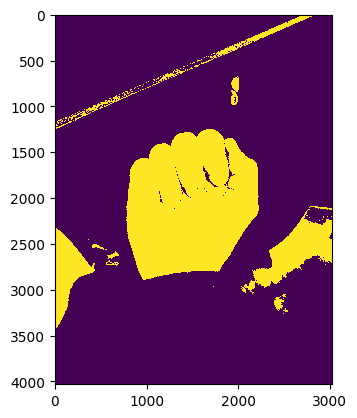

In [18]:
def is_skin_from_histo(pixel, histo_peau, histo_non_peau):
    c1, c2 = pixel[1], pixel[2]
    return histo_peau[c1 // 8][c2 // 8] > histo_non_peau[c1 // 8][c2 // 8]


def createSkinMask_from_histo(src, histo_peau, histo_non_peau):
    img = cv2.imread(src, 1)
    height, width = img.shape[:2]
    mask = np.zeros((height, width), np.uint8)
    for i in range(height):
        for j in range(width):
            if is_skin_from_histo(img[i][j], histo_peau, histo_non_peau):
                mask[i][j] = 255
    return mask


skinMask = createSkinMask_from_histo(
    "./data/A_real.jpg",
    hist_peau_RG,
    hist_non_peau_RG,
)
plt.imshow(skinMask, interpolation="nearest")

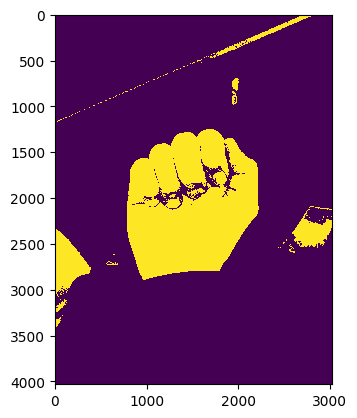

In [20]:
def is_skin_from_histo_with_bayes(
    pixel, histo_peau, histo_non_peau, peau_prior, nonpeau_prior, theta
):
    c1, c2 = pixel[1], pixel[2]
    num = histo_peau[c1 // 8][c2 // 8] * peau_prior
    denum = (
        histo_peau[c1 // 8][c2 // 8] * peau_prior
        + histo_non_peau[c1 // 8][c2 // 8] * nonpeau_prior
    )
    if denum == 0:
        return False
    return num / denum > theta


def createSkinMask_from_histo_with_bayes(
    src, histo_peau, histo_non_peau, peau_prior, nonpeau_prior, theta
):
    img = cv2.imread(src, 1)
    height, width = img.shape[:2]
    mask = np.zeros((height, width), np.uint8)
    for i in range(height):
        for j in range(width):
            if is_skin_from_histo_with_bayes(
                img[i][j], histo_peau, histo_non_peau, peau_prior, nonpeau_prior, theta
            ):
                mask[i][j] = 255
    return mask


skinMask = createSkinMask_from_histo_with_bayes(
    "./data/A_real.jpg", hist_peau_RG, hist_non_peau_RG, peau_prior, non_peau_prior, 0.8
)
plt.imshow(skinMask, interpolation="nearest")

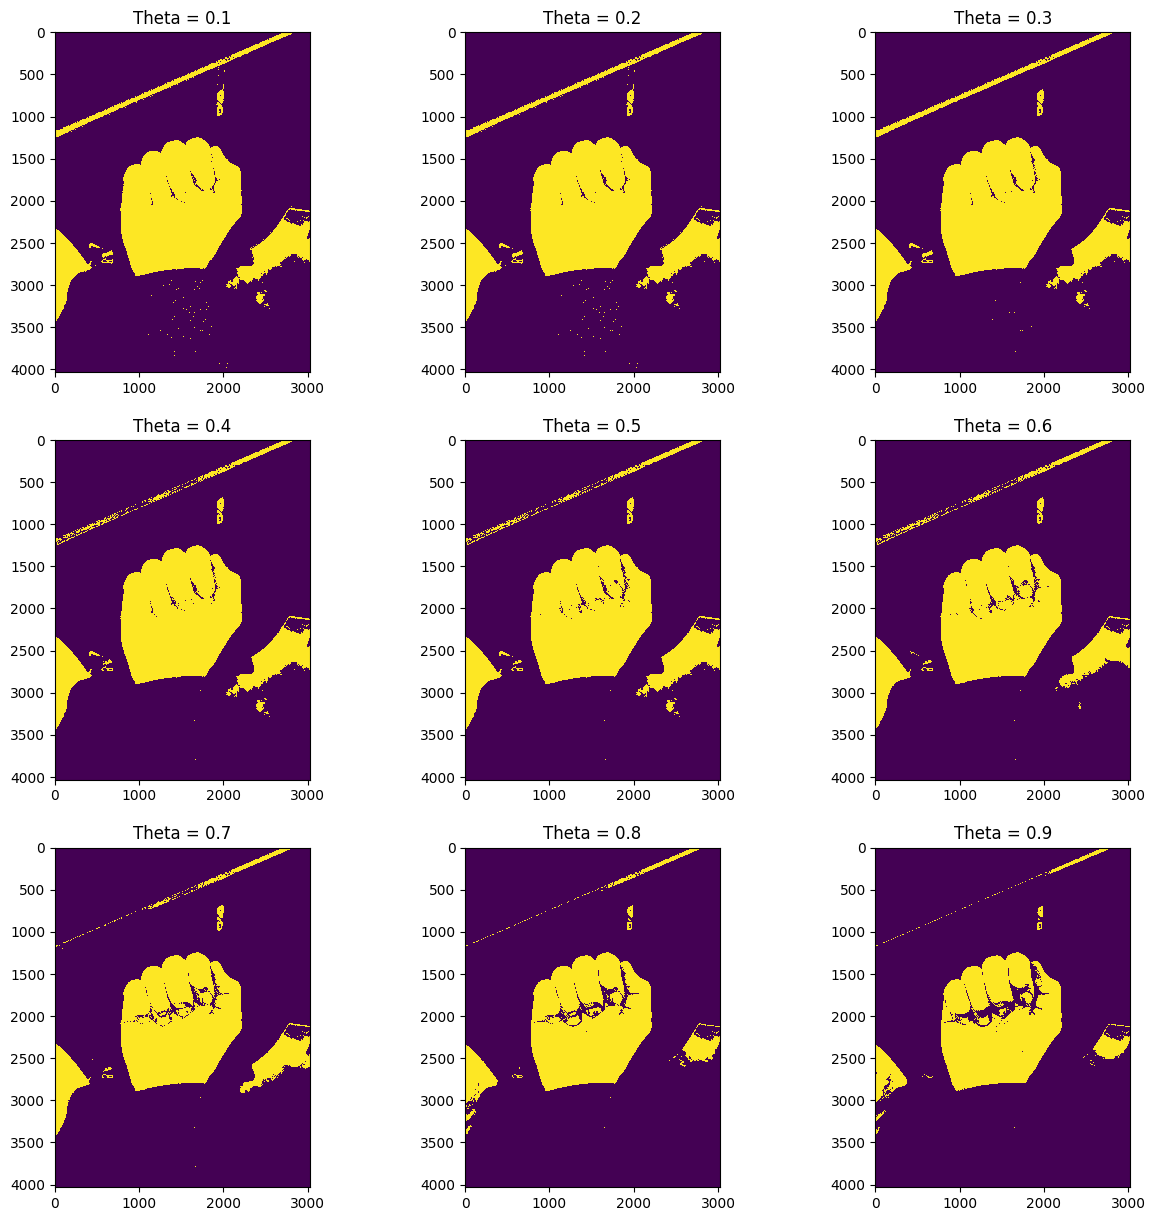

In [22]:
# Test createSkinMask_from_histo_with_bayes avec theta qui varie de 0.1 à 0.9 avec un pas de 0.1
# Affiche les images sur une grille de 3x3
plt.figure(figsize=(15, 15))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    skinMask = createSkinMask_from_histo_with_bayes(
        "./data/A_real.jpg",
        hist_peau_RG,
        hist_non_peau_RG,
        peau_prior,
        non_peau_prior,
        i / 10,
    )
    plt.imshow(skinMask, interpolation="nearest")
    plt.title(f"Theta = {i / 10}")